# Week 4 - Classification

This week, we shift from gathering human textual classifications through crowdsourcing, to using machine learning models and algorithms that train on those human classifications and extend them to documents far too numerous to read. If you recall, *clustering* allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. *Classification*, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

In this notebook, we will show how to use a variety of classification methods, including Naïve Bayes, Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

For this notebook we will be using the following packages.

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

# Simple Simulated Examples

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

In [11]:
noise = .6

#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.random())
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.andSplit(noise))
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.xorSplit(noise)) #Please try this one
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.targetSplit(noise))
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.multiBlobs(noise))

We can easily visualize the rendered datasets because they are generated in two dimensions.

Let's see what dfTrain, a simulated data that we just made, looks like

In [12]:
dfTrain

,vect,category
700,"[0.6270779382953602, -0.604056528683228]",0
92,"[0.351224969363693, 0.5371464766457914]",0
295,"[0.003757219971930681, 0.06051595642999952]",1
161,"[0.044527362257676395, 0.28920066690984547]",1
741,"[-0.2837113954499861, -0.693276063310653]",1
...,...,...
485,"[-0.4615442873835611, -0.4237722549997198]",1
283,"[-0.4074587811413203, 0.7802731817280559]",1
34,"[-0.18801023909542058, 0.058342876779598596]",0
814,"[0.5108098187436957, -0.3388992548376448]",0


So, dfTrain has two columns, vect and category. 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


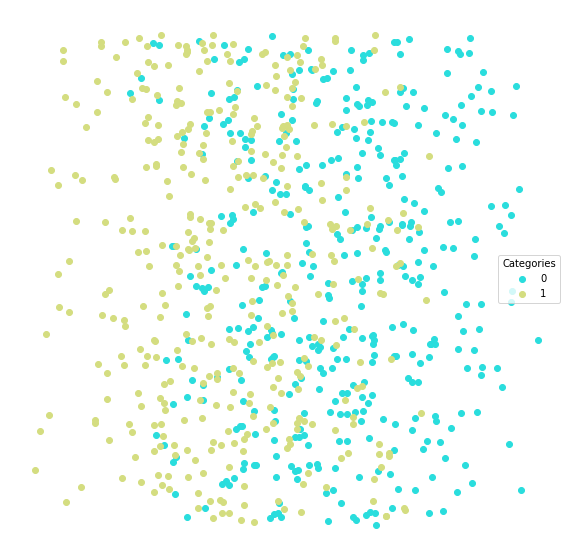

In [13]:
lucem_illud.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [14]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

We're using sklearn here. What is sklearn? It's an open source machine learning library for Python. We use sklearn because it features various machine learning algorithms and it works well with NumPy library. You don't need to understand the sklearn package in detail for the moment, but let's see what methods and attributes sklearn has, because we're going to use some of them:

In [15]:
dir(sklearn)

['__SKLEARN_SETUP__',
 '__all__',
 '__builtins__',
 '__cached__',
 '__check_build',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_config',
 '_distributor_init',
 'base',
 'clone',
 'config_context',
 'datasets',
 'decomposition',
 'dummy',
 'ensemble',
 'exceptions',
 'externals',
 'feature_extraction',
 'get_config',
 'linear_model',
 'logger',
 'logging',
 'metrics',
 'model_selection',
 'naive_bayes',
 'neighbors',
 'neural_network',
 'os',
 'preprocessing',
 're',
 'set_config',
 'setup_module',
 'show_versions',
 'svm',
 'sys',
 'tree',
 'utils']

Now we fit the model by giving it our training data

In [16]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Here, "stack" function is used. Why did we use stack function here? This is because dfTrain['vect'] is a sequence, while clf.fit() takes an array element. Let's see what dfTrain['vect'] looks like:

In [17]:
dfTrain['vect']

700        [0.6270779382953602, -0.604056528683228]
92          [0.351224969363693, 0.5371464766457914]
295     [0.003757219971930681, 0.06051595642999952]
161     [0.044527362257676395, 0.28920066690984547]
741       [-0.2837113954499861, -0.693276063310653]
                           ...                     
485      [-0.4615442873835611, -0.4237722549997198]
283       [-0.4074587811413203, 0.7802731817280559]
34     [-0.18801023909542058, 0.058342876779598596]
814       [0.5108098187436957, -0.3388992548376448]
895       [-0.7961591194503864, 0.7150437877488434]
Name: vect, Length: 800, dtype: object

And let's see what np.stack(dfTrain['vect']) does:

In [18]:
np.stack(dfTrain['vect'])

array([[ 0.62707794, -0.60405653],
       [ 0.35122497,  0.53714648],
       [ 0.00375722,  0.06051596],
       ...,
       [-0.18801024,  0.05834288],
       [ 0.51080982, -0.33889925],
       [-0.79615912,  0.71504379]])

As you can see, stack function takes a sequence of arrays (which have the same shape) and joins them along a new axis.

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set

In [19]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.27,0.736364,0.666667,0.623333,0.800000
1,0.27,0.736364,0.804348,0.721107,0.672727


This lets us look at which classes do better:

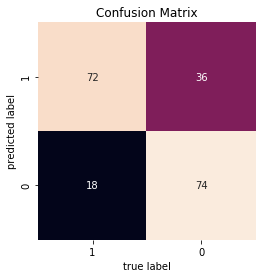

In [20]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

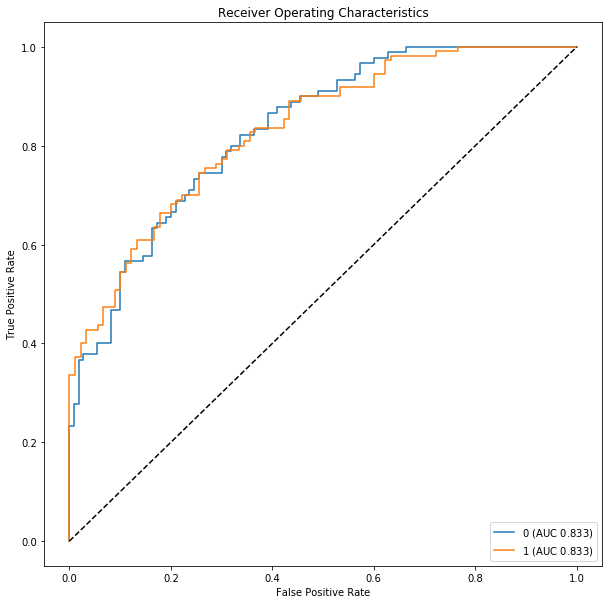

In [21]:
lucem_illud.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


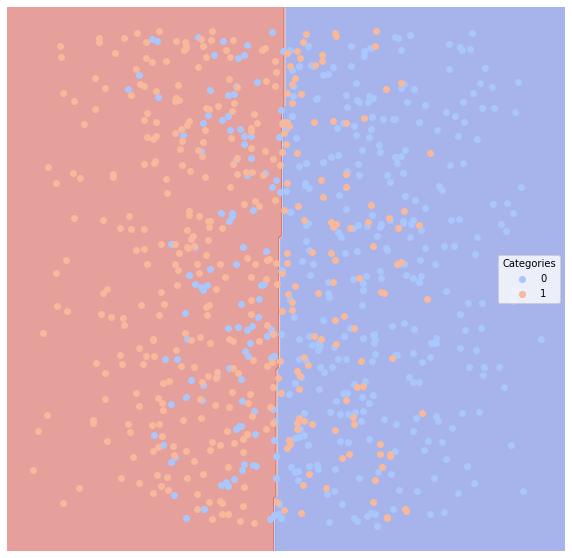

In [22]:
lucem_illud.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

In [129]:
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadReddit())
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadNewsGroups())
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadSenateSmall())
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadSenateLarge())
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadSpam())

Loading data for: comp.sys.mac.hardware
Loading data for: comp.windows.x
Loading data for: misc.forsale
Loading data for: rec.autos
Converting to vectors


In [130]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [131]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [132]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
comp.sys.mac.hardware,0.063830,0.904199,0.888889,0.786836,0.842105
comp.windows.x,0.042553,0.937916,0.917431,0.849919,0.900901
rec.autos,0.051064,0.947315,0.892617,0.858994,0.943262
misc.forsale,0.055319,0.919740,0.875000,0.793285,0.875000


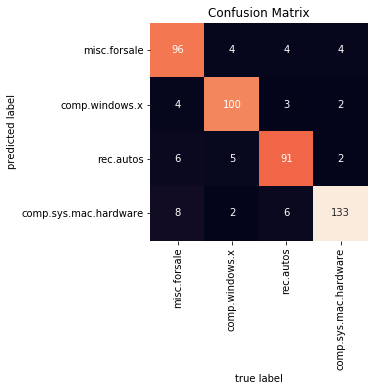

In [133]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

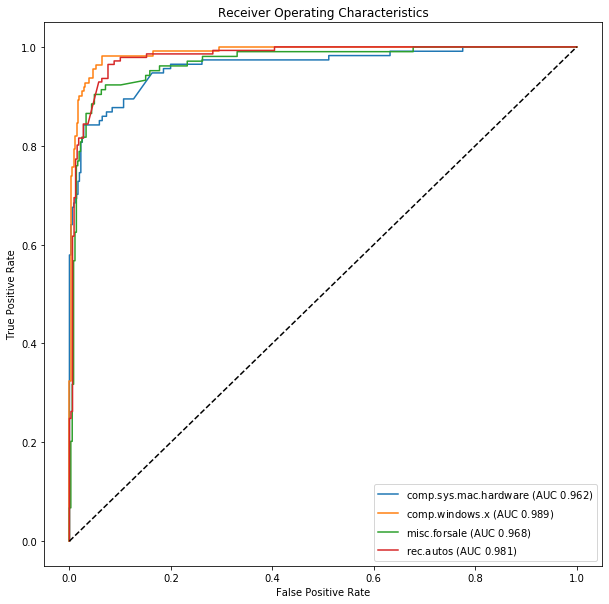

In [134]:
lucem_illud.plotMultiROC(clf, dfTest)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

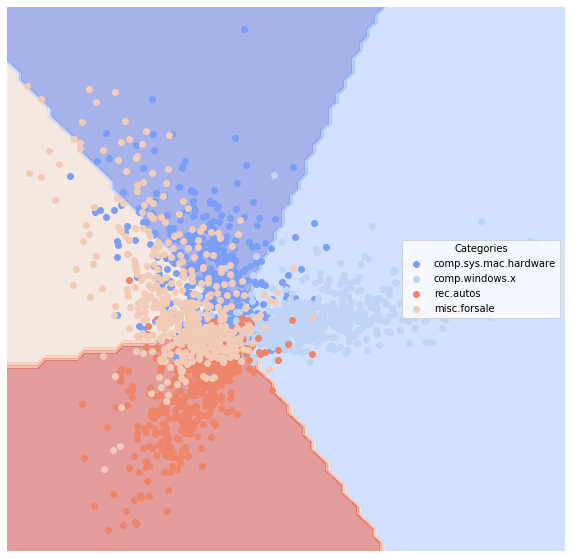

In [135]:
lucem_illud.plotregions(clf, dfTrain)

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<span style="color:red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

**Artifical Datasets**

I generated 2 artificial datasets for each of the five data patterns, one with lower noise (0.2) and one with higher noise (0.6).

For both randomly distributed datasets, all classifiers performed poorly with around 0.5 AUC, around what would be expected if classification was done randomly. That makes sense given that the datasets were random...

For the linearly split datasets, the linear Support Vector Classification and classical regression classifier performed best, at 0.98 AUC for the 0.2 noise model and 0.776 AUC for the 0.6 noise model. These models are well-suited here because of the linear separation of the classes. Naive Bayes classification and the MLP neural network model were both almost as strong, also achieiving 0.98 AUC for the 0.2 noise dataset but slightly less accurate for the 0.6 noise dataset.

For the xorSplit datasets, the MLP neural network model performed the best, at 0.98 AUC for 0.2 noise and 0.776 AUC  for 0.6 noise. The neural network worked well here because it was able to learn non-linear mappings, as opposed to the models that worked best for the linearly split datasets.

For the targetSplit datasets, the Naive Bayes model performed (0.98 annd 0.769 AUC), followed by the neural network (0.976 and 0.766 AUC). Again, the more linearly suited models did not perform well for these nested classes.

Many models performed well on the "multiBlobs" datasets: the Naive Bayes model, both Support Vector models, the classical regression model, the neural network model, and the ensemble model all achieved from 0.997-1 AUC for the various classes with 0.2 noise and 0.963-1 AUC for the classes with 0.6 noise. These classes had distinct spatial separations that both linear splits and a polynomial split were able to classify succesfully.

**Real Datasets**

The linear SVC and classical regression classifiers were among the strongest models for classifying Reddit threads, newgroups, and Senate press releases from 2 senators, suggesting that the classes in these models were separated with fairly linear splits. The boosting ensemble classifier was also very strong for the Reddit threads and Senate press releases, while the neural network was very strong for the newsgroups.

For both sets of Senate press releases, the random forest model and boosting model performed at 1 AUC, extremely high accuracy. These ensemble decision tree methods were likely successful because they reduced the tendency to overfit. The random forest model was also the most successful model for the spam email dataset, with 0.931 AUC. Other models did not perform as well on this dataset, suggesting that spam emails may have less separation from other emails than the classes in the other sets.

Interestingly, the Naive Bayes model performed worse for these datasets than it did for most artificial datasets--this is probably because the independence assumption is violated for each of these real data sources.

***Stretch***: I'll use the AdaBoost classifier.

In [214]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

In [236]:
clf = AdaBoostClassifier(n_estimators=100)

I'm first going to try it on the xorSplit data pattern, as this was one of the more difficult artifical datasets to model.

In [247]:
noise = 0.2
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.xorSplit(noise))

In [248]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=None)

In [249]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.525,0.483827,0.546512,0.557310,0.415929
1,0.525,0.483827,0.421053,0.427305,0.551724


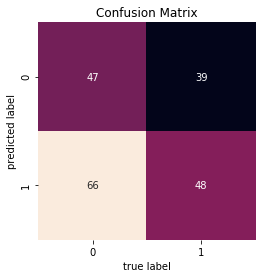

In [250]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

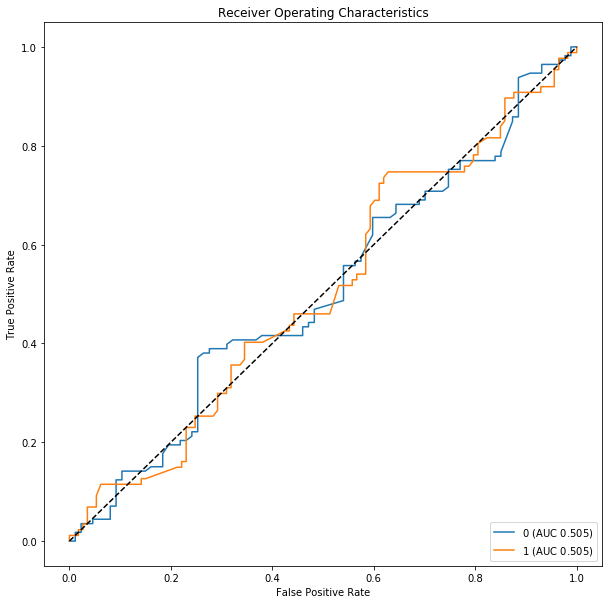

In [251]:
lucem_illud.plotMultiROC(clf, dfTest)

It was pretty useless, about what would be expected from a random classification. Next I'll try with the spam emails dataset.

In [252]:
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadSpam())

Loading Spam
Loading Ham
Converting to vectors


In [253]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=None)

In [254]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
spam,0.115497,0.689122,0.661290,0.358663,0.414141
not spam,0.115497,0.689122,0.906752,0.904904,0.964103


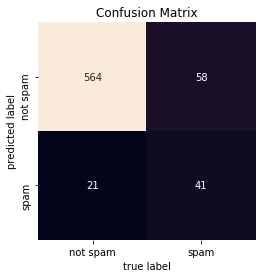

In [255]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

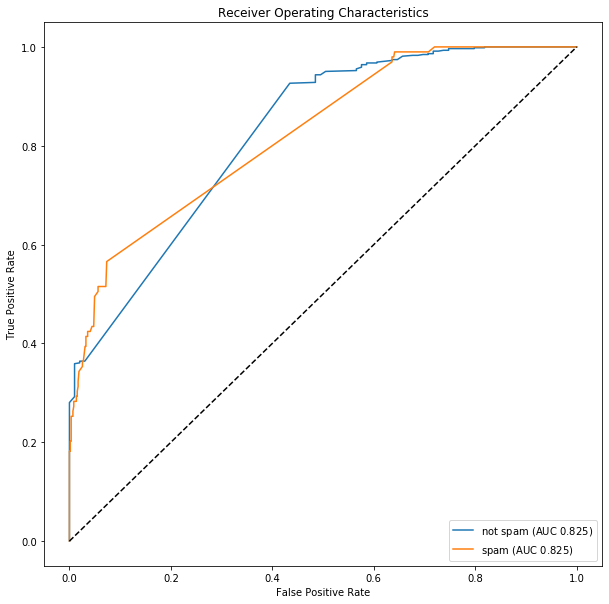

In [256]:
lucem_illud.plotMultiROC(clf, dfTest)

0.825 AUC, not nearly as successful as the random forest model. It may be that AdaBoost is overfitting the data.

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest? 

In [82]:
ObamaClintonReleases = pandas.read_csv('../data/ObamaClintonReleases.csv', index_col=0)

I'm pretty sure that you're all familiar with pandas, but, just to clarify: why do we use pandas here? pandas is a Python library which is widely used for analyzing and wrangling data. In particular, pandas loads data and creates data frame, a Python object that looks familiar to us (since it looks like a excel table) and easy to work with. So, using pandas.read_csv function, we take in the csv file and convert it into a data frame. 

In [83]:
type(ObamaClintonReleases)

pandas.core.frame.DataFrame

It's a DataFrame! and it looks like this:

In [84]:
ObamaClintonReleases

,download_url,html_url,name,path,text,targetSenator
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...,Obama
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Obama108.txt,raw/Obama/10Apr2008Obama108.txt,Statement from Senator Barack Obama on the ...,Obama
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama674.txt,raw/Obama/10Aug2005Obama674.txt,Obama Says Bill Will Help Cut Off Supply of...,Obama
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama675.txt,raw/Obama/10Aug2005Obama675.txt,Obama Durbin Say Illinois Will Receive 33 ...,Obama
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2006Obama508.txt,raw/Obama/10Aug2006Obama508.txt,Obama Introduces Bill to Help Tap Power of ...,Obama
...,...,...,...,...,...,...
1704,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton285.txt,raw/Clinton/1Sep2005Clinton285.txt,September 1 2005 Senator Clinton Visit Infoto...,Clinton
1705,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton286.txt,raw/Clinton/1Sep2005Clinton286.txt,September 1 2005 Senator Clinton Announces Ex...,Clinton
1706,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton287.txt,raw/Clinton/1Sep2005Clinton287.txt,September 1 2005 Senator Clinton Joins Local ...,Clinton
1707,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2006Clinton207.txt,raw/Clinton/1Sep2006Clinton207.txt,September 1 2006 Clintons Meet with Cazenovia...,Clinton


Neat! Let's turn the 'targetSenator' column into a binary category variable.

In [85]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [87]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

Let's split the data into training data and testing data.

In [89]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud.trainTestSplit(ObamaClintonReleases, holdBackFraction=holdBackFraction)

In [90]:
print(len(train_data_df))
print(len(test_data_df))

1368
341


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud_2020.generateVecs()` will help with this but for now we are doing it the long way):

In [91]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

The core function here is TfidfVectorizer, which takes a collection of raw documents and turn them to a tf-idf matrix. Just to recap: tf-idf means term frequency-inverse document frequency, a statistic (or, more precisely, a product of two statistics, term frequency and inverse document frequency) that shows the importance of a term vis-a-vis documents. TF, or, term frequency, counts how many times a term is used in a document; IDF, or, inverse-document-frequency, measures common or rare a term appears across documents. 

Let's look at three parameters of TfidfVectorizer: max_df = 100, min_df = 2, and norm='l2'. What do those parameters mean? 

(1) max_df = 100

Here, we specified a thredhold of 100, and the terms that have a document frequency higher than 100 would be ignored.

(2) min_df = 2

We specified a lower bound, 2, and the terms that have a document frequency lower than 2 will be ignored.

(3) norm = 'l2'

This parameter is about vector normalization. In machine learning, we commonly normalize vectors, i.e., change the length of vectors and turn them into a unit vector, before passing them into algorithms. There are various ways of normalizations, and this parameter specifies how we normalize vectors. Here, we set the norm to l2, in which case, we normalize the vectors such that squares of vector elements sums to 1. Alternatively, we can set it to l1, in which case the sum of absolute values of vector elements, not the square of vector elements, is 1. 

fit_transform() literally fits to data and then transform it. So, fit_transform() is just a combination of two steps--(1) fitting parameters to data; (2) then, using the vocabulary and document frequencies learned by fit(), transforming documents into document-term matrix. So, it's the same as fit followed by transform. 

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [92]:
TFVects.shape

(1368, 11407)

We can save this in the dataframe to make things easier

In [93]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

Looks simple, but we need to know what todense() does here. todense() returns a dense matrix representation of the matrix. Why do we need this? As you can see above, the TFVects, a document-term matrix, has 11349 columns, and this matrix is sparse, in the sense that it is comprised mostly of zeros. Dense matrices, in contrast, are the matrices that are comprised of mostly non-zeros. Then why do we make sparse matrices into dense ones? Because zero values don't contain important information but take up so much memory.

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [94]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [95]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


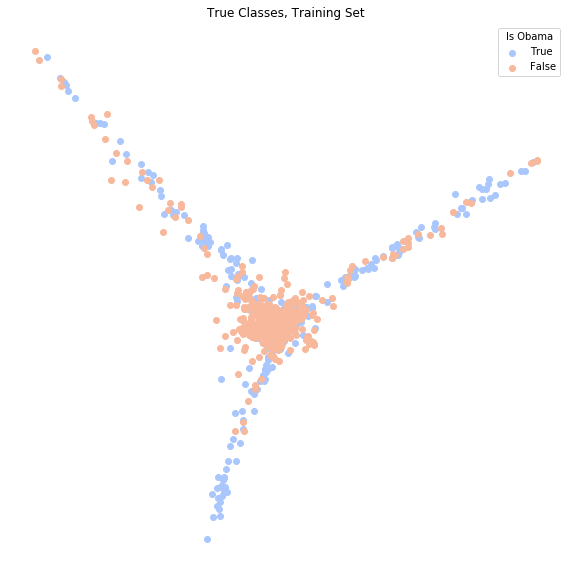

In [96]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

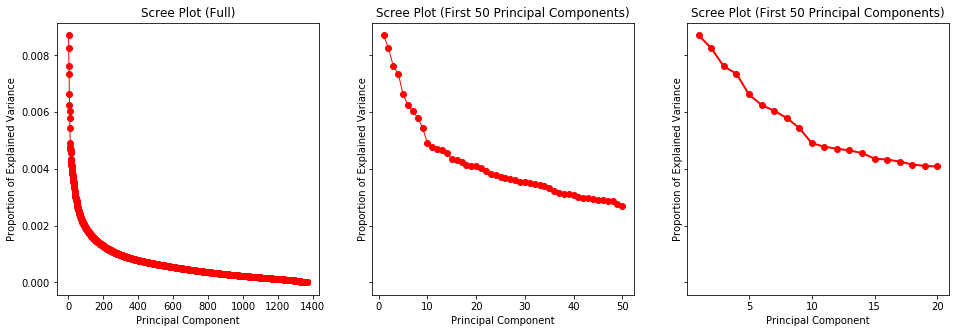

In [97]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [98]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [99]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [100]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.6652046783625731

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [101]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.6275659824046921

Slightly poorer. How about using more dimensions (40)?

In [102]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7441520467836257
Testing:
0.7067448680351907


Or still more (100)?

In [103]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8326023391812866
Testing:
0.7653958944281525


Or even more (200)!

In [104]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8676900584795322
Testing:
0.7947214076246334


This is becoming ridiculous (400)!

In [105]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.908625730994152
Testing:
0.8299120234604106


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [106]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.9539473684210527


Train the model using training data, and then test it on the testing data.

In [107]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.8328445747800587


81% accuracy seems like the best we can get by using a logistic regression.

Now let's try with Naive Bayes. Classically, it is trained with word counts, but TF-IDF vectors are also quite good:

In [108]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [109]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.9583333333333334
Testing:
0.8768328445747801


A bit better than the logit, but that's just looking at the accuracy. What about other measures? Let's first save the predictions in the dataframe to save use rerunning the model every time:

In [110]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

Precision:

In [111]:
sklearn.metrics.precision_score(test_data_df['category'], test_data_df['nb_predict'])

0.8571428571428571

Recall:

In [112]:
sklearn.metrics.recall_score(test_data_df['category'], test_data_df['nb_predict'])

0.8571428571428571

F1-measure:

In [113]:
sklearn.metrics.f1_score(test_data_df['category'], test_data_df['nb_predict'])

0.8571428571428571

Let's take a look at how well our posterior distribution looks relative to the truth.

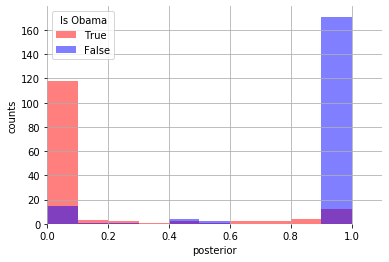

In [114]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['category'].eq(True)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['category'].eq(False)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Is Obama")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

The classification is suprisingly accurate. We can even look at what words are most influential with a bit of simple math:

In [115]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Obama' : [],
    'Obama_log_prob' : [],
    'Clinton' : [],
    'Clinton_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Obama'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Obama_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Clinton'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Clinton_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

,Obama,Obama_log_prob,Clinton,Clinton_log_prob
0,signature,-2.228654,5566,-1.770706
1,announcement,-2.263745,friday,-1.802455
2,welcomed,-2.275721,amy,-1.835245
3,fy,-2.300113,brundage,-1.904237
4,continued,-2.350757,dick,-1.940605
5,urging,-2.363829,chicago,-2.044595
6,ground,-2.377074,reform,-2.160667
7,read,-2.390497,temporary,-2.176171
8,growing,-2.431882,oversight,-2.257517
9,having,-2.446067,location,-2.309703


## Multinomial Naive Bayes

What if we want to classify our text into one of *many* classes? The multinomial Naive Bayes generating model assumes that document features (e.g., words) are generated by draws from a multinomial distribution (recall this gives the probability to observe a particular pattern of counts across features). 

Let's use again the dataset we used in week 3, the 20 newsgroup dataset.

In [419]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus.
newsgroups.target_names #Possible categories, i.e., the newsgroups

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

We can pick specific categories, and pull the relevant training and testing sets. 

In [424]:
target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

Loading data for: talk.religion.misc
Loading data for: soc.religion.christian
Loading data for: sci.space
Loading data for: comp.graphics


Now we need to tokenize, and make a training and testing set:

In [425]:
newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: lucem_illud.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [426]:
newsgroupsDF

,text,category,source_file,tokenized_text,normalized_text
0,\n\nParadise and salvation are not the same th...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[Paradise, and, salvation, are, not, the, same...","[paradise, salvation, thing, salvation, well, ..."
1,\nYou're admitting a lot more than that. You ...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[You, 're, admitting, a, lot, more, than, that...","[admit, lot, admit, moral, situational, admit,..."
2,"\n\nJesus also recognized other holy days, lik...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[Jesus, also, recognized, other, holy, days, l...","[jesus, recognize, holy, day, like, passover, ..."
3,In <lsjc8cINNmc1@saltillo.cs.utexas.edu> turpi...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[In, <, lsjc8cINNmc1@saltillo.cs.utexas.edu, >...","[<, lsjc8cinnmc1@saltillo.cs.utexas.edu, >, tu..."
4,"\nI'm sorry, but He does not! Ever read the F...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[I, 'm, sorry, but, He, does, not, Ever, read,...","[be, sorry, read, commandment]"
...,...,...,...,...,...
2148,This article was probably generated by a buggy...,comp.graphics,../data/20news_home/20news-bydate-train/comp.g...,"[This, article, was, probably, generated, by, ...","[article, probably, generate, buggy, news, rea..."
2149,Hi all!\n\tI've just recently become seriously...,comp.graphics,../data/20news_home/20news-bydate-train/comp.g...,"[Hi, all, I, 've, just, recently, become, seri...","[hello, have, recently, seriously, hook, pov, ..."
2150,Hi !!! This is the response for Wayne Michael....,comp.graphics,../data/20news_home/20news-bydate-train/comp.g...,"[Hi, This, is, the, response, for, Wayne, Mich...","[hello, response, wayne, michael, certainly, b..."
2151,I was recently talking to a possible employer ...,comp.graphics,../data/20news_home/20news-bydate-train/comp.g...,"[I, was, recently, talking, to, a, possible, e...","[recently, talk, possible, employer, reference..."


In [121]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

In [122]:
print(len(train_ng_df))
print(len(test_ng_df))

1723
430


We need to extract features from the text. We can use built-in feature extraction to do so. We will use a tf-idf vectorizer, which converts the document into a vector of words with tf-idf weights (term-frequency inverse-document frequency). This gives high weight to words that show up a lot in a given document, but rarely across documents in the corpus (more distinctive). 

In [123]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

Now we can train the model:

In [124]:
MultinomialNB_ng = sklearn.naive_bayes.MultinomialNB()
MultinomialNB_ng.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

...and save predictions to the dataframe:

In [125]:
train_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(train_ng_df['vect'], axis=0))
print("Training score:")
print(MultinomialNB_ng.score(np.stack(train_ng_df['vect'], axis=0), train_ng_df['category']))

Training score:
0.8932095182820662


In [126]:
train_ng_df[['category', 'nb_predict']][:10]

,category,nb_predict
2023,comp.graphics,comp.graphics
1970,comp.graphics,soc.religion.christian
2106,comp.graphics,comp.graphics
1692,comp.graphics,comp.graphics
2027,comp.graphics,soc.religion.christian
1251,sci.space,sci.space
492,soc.religion.christian,soc.religion.christian
560,soc.religion.christian,soc.religion.christian
37,talk.religion.misc,soc.religion.christian
1100,sci.space,sci.space


Looks pretty good, lets examine the testing dataset:

In [127]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(MultinomialNB_ng.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.7906976744186046


We can even use a confusion matrix, like we used last week for evaluating human coders relative to one another. Now we are evaluating our classifier relative to human coding. We'll just use the one in `lucem_illud_2020`, which requres a classifier and a dataframe with `'vect'` and `'category'` columns, like we have in the examples:

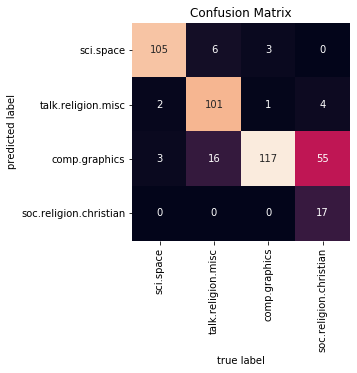

In [129]:
lucem_illud.plotConfusionMatrix(MultinomialNB_ng, test_ng_df)

Let's calculate the precision, recall, and F-measures.

In [133]:
print(sklearn.metrics.precision_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #F-1 measure

0.8522418281386733
0.7906976744186046
0.7656241576627925


We can evaluate these per catagory. This has the same requiments as `plotConfusionMatrix`:

In [135]:
lucem_illud.metrics.evaluateClassifier(MultinomialNB_ng, test_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
soc.religion.christian,0.181395,0.863730,0.612565,0.601618,0.966942
talk.religion.misc,0.137209,0.611842,1.000000,0.360894,0.223684
comp.graphics,0.032558,0.963210,0.921053,0.890815,0.954545
sci.space,0.067442,0.899168,0.935185,0.819079,0.821138


We can also plot the ROC curves. This has the same requiments as `plotConfusionMatrix`:

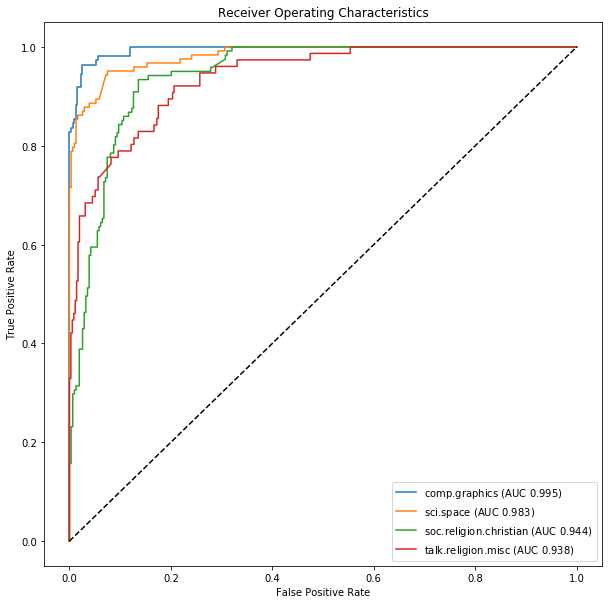

In [137]:
lucem_illud.plotMultiROC(MultinomialNB_ng, test_ng_df)

And we can plot the PCA space visualization:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

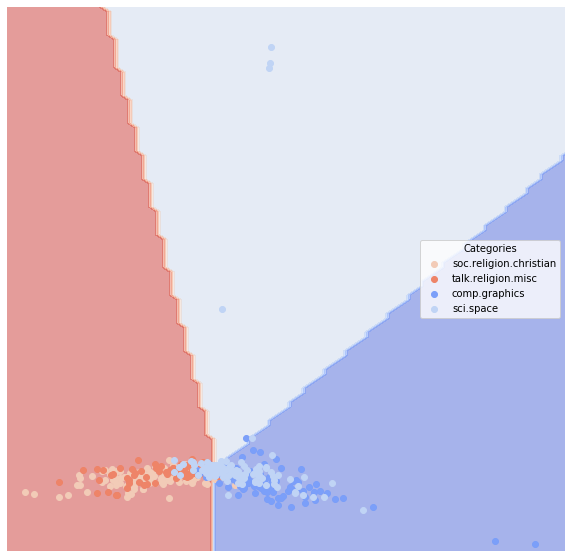

In [138]:
lucem_illud.plotregions(MultinomialNB_ng, test_ng_df)

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform Logistic and Naïve Bayes classification (binary or multinomial) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


I plan to compare fanfiction and its source material for my project, so I'll use a dataset with *Doctor Who* story texts classified as either TV episodes, or fanfiction works. First, I'll load and organize a *Doctor Who* subcorpus I've extracted from the Davies TV Corpus.

In [328]:
DoctorWhoTV = pandas.read_csv('TVDataFrames/Doctor_Who.csv', index_col=0)

In [329]:
DoctorWhoTV

,Episode,Genre,Year,Country,Tokenized Texts
Series,,,,,
Doctor Who,An Unearthly Child,"Adventure, Drama, Family",1963,UK,"['Doctor', 'Who', 'Episode1', 'Season', '1', '..."
Doctor Who,The Cave of Skulls,"Adventure, Drama, Family",1963,UK,"['DOCTORWHOTHEME', 'Where', 'is', 'the', 'fire..."
Doctor Who,The Dead Planet,"Adventure, Drama, Family",1963,UK,"['Well', 'I', 'suggest', 'before', 'we', 'go',..."
Doctor Who,The Firemaker,"Adventure, Drama, Family",1963,UK,"['Back', 'Get', 'back', 'They', 'are', 'coming..."
Doctor Who,The Forest of Fear,"Adventure, Drama, Family",1963,UK,"['DOCTORWHOTHEME', 'Oh', 'I', ""'m"", 'sorry', '..."
...,...,...,...,...,...
Doctor Who,The Lie of the Land,"Adventure, Drama, Family",2017,UK,"['The', 'Monks', 'have', 'been', 'with', 'us',..."
Doctor Who,The Pilot,"Adventure, Drama, Family",2017,UK,"['CLOCK', 'TICKS', 'RHYTHMICALLY', 'FOOTSTEPS'..."
Doctor Who,The Pyramid at the End of the World,"Adventure, Drama, Family",2017,UK,"['A', 'few', 'months', 'ago', 'the', 'Veritas'..."


In [330]:
DoctorWhoTV['class'] = 'TV'

In [331]:
DoctorWhoTV['Text'] = DoctorWhoTV['Tokenized Texts'].apply(''.join)

In [332]:
DWTV = DoctorWhoTV[["class", "Tokenized Texts", "Text"]]

In [333]:
DWTV

,class,Tokenized Texts,Text
Series,,,
Doctor Who,TV,"['Doctor', 'Who', 'Episode1', 'Season', '1', '...","['Doctor', 'Who', 'Episode1', 'Season', '1', '..."
Doctor Who,TV,"['DOCTORWHOTHEME', 'Where', 'is', 'the', 'fire...","['DOCTORWHOTHEME', 'Where', 'is', 'the', 'fire..."
Doctor Who,TV,"['Well', 'I', 'suggest', 'before', 'we', 'go',...","['Well', 'I', 'suggest', 'before', 'we', 'go',..."
Doctor Who,TV,"['Back', 'Get', 'back', 'They', 'are', 'coming...","['Back', 'Get', 'back', 'They', 'are', 'coming..."
Doctor Who,TV,"['DOCTORWHOTHEME', 'Oh', 'I', ""'m"", 'sorry', '...","['DOCTORWHOTHEME', 'Oh', 'I', ""'m"", 'sorry', '..."
...,...,...,...
Doctor Who,TV,"['The', 'Monks', 'have', 'been', 'with', 'us',...","['The', 'Monks', 'have', 'been', 'with', 'us',..."
Doctor Who,TV,"['CLOCK', 'TICKS', 'RHYTHMICALLY', 'FOOTSTEPS'...","['CLOCK', 'TICKS', 'RHYTHMICALLY', 'FOOTSTEPS'..."
Doctor Who,TV,"['A', 'few', 'months', 'ago', 'the', 'Veritas'...","['A', 'few', 'months', 'ago', 'the', 'Veritas'..."


Here's a corpus of *Doctor Who* fanfic stories from archiveofourown.org.

In [334]:
DoctorWhoFanFic = pandas.read_csv('FanFicData/Doctor_Who_FicScrape.csv', index_col=0)

In [335]:
DoctorWhoFanFic

,title,author,rating,category,fandom,relationship,character,additional tags,language,published,...,status date,words,chapters,comments,kudos,bookmarks,hits,all_kudos,all_bookmarks,body
work_id,,,,,,,,,,,,,,,,,,,,,
335149,Scratching the Itch,['bendingsignpost'],Explicit,F/M,Doctor Who (2005),Tenth Doctor/Rose Tyler,"Tenth Doctor, Rose Tyler","First Time, Alien Biology",English,2012-02-08,...,2012-02-07,19689,3/3,70,2889,505,55534,"['galiifreywolf', 'AgnesTomlinson', 'Rohnoc', ...","['jacqkoz', 'Sa_forever', 'DailyDay', 'Dwarf23...","""Wait, hold on, no."" Rose caught at his sleeve..."
97380,The Care and Feeding of Tiny Humans (and sligh...,['Netgirl_y2k'],General Audiences,Gen,Doctor Who (2005),NaN,"Amelia Pond, Sarah Jane Smith, River Song, Ele...",NaN,English,2010-06-29,...,2010-06-29,1126,1/1,119,2715,663,28402,"['lazlong', 'Darki1905', 'cooperussery', 'morg...","['morganfm', 'blackfyre_007', 'Spidertape', 'e...",The Doctor stepped out of his stupendous new T...
90471,"Seventeen Things That Happen to Rory Williams,...",['Scribe'],Teen And Up Audiences,M/M,Doctor Who,Rory Williams/Eleventh Doctor,"Rory Williams, Eleventh Doctor, Jack Harkness,...",NaN,English,2010-05-29,...,2010-05-29,7682,1/1,109,2634,619,44624,"['TNineL', 'Sud0Command', 'cy_owns_this_whoreh...","['cy_owns_this_whorehouse', 'IdlewildIsbold', ...",The worst thing about it (not the worst thing ...
6218785,Connect-the-Dots,['fingersfallingupwards'],Teen And Up Audiences,F/M,"Doctor Who (2005), Doctor Who & Related Fandoms","Tenth Doctor/Rose Tyler, Eleventh Doctor/Rose ...","Rose Tyler, Eleventh Doctor, Tenth Doctor, Nin...","Soulmates, Soulmate-Identifying Marks, Alterna...",English,2016-03-11,...,2016-03-11,17176,1/1,146,2631,562,27302,"['ViceroyMarx', 'flaxweave', 'wanderingdoe', '...","['nokreli', 'shesmyplusone', 'actually_grantai...","Not everyone on Earth has one, but enough peop..."
1566272,Rose Petals,['LicieOIC'],Explicit,F/M,"Doctor Who, Doctor Who (2005)",Tenth Doctor/Rose Tyler,"Tenth Doctor, Rose Tyler, Jackie Tyler, Jack H...","Fluff and Crack, Courtship, Alien Rituals, Exp...",English,2014-05-04,...,2014-05-10,14753,8/8,178,1274,162,18071,"['ErinArgonian', 'shatterdame', 'Lenchika', 'S...","['Srakatsz', 'covur', 'JelloMarshmallowGlade',...",\n\n\n\nIt was time. He'd nearly lost her agai...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16764289,Should Auld Acquaintance Be For- What?!,['rowanthestrange_yugihell'],Teen And Up Audiences,F/F,"Doctor Who, Doctor Who (2005), Doctor Who & Re...","The Doctor/River Song, Thirteenth Doctor/River...","Ryan Sinclair, River Song, Thirteenth Doctor, ...","Scenes We'd Like To See, Fun With The New Year...",English,2018-11-27,...,2018-11-27,1079,1/1,42,493,50,2830,"['SapphoGiveMeStrength', 'MoonAsAcolyte', 'hed...","['Hazel_Doorkeeper', 'Bunnies306', 'desconheci...",\n\n\nThe sound of something smashing to the f...
2078412,Never Alone For Very Long,['Whovian_Overload'],Mature,"F/M, Multi",Doctor Who,"Eleventh Doctor/River Song, Jack Harkness/Iant...","River Song, The Doctor (Doctor Who), OC Childr...","Smut, Angst, Fluff, Pregnancy, Episode Fix-It:...",English,2014-08-04,...,2016-04-20,466847,163/163,227,492,15,19276,"['CharlieConsby', 'badwolfkaily', 'azerty29', ...","['JuliaKuch013', 'Hiding_in_my_head', 'Hiding_...",\nCh 1\n\n\n\nRiver stumbled through the doors...
23144170,Delirium,['zaffrin'],Explicit,Multi,Doctor Who (2005),"Thirteenth Doctor/The Master (Dhawan), Thirtee...","Thirteenth Doctor, The Master (Dhawan), Yasmin...","Sex Pollen, tropey af, Dubious Consent, becaus...",English,2020-03-14,...,2020-03-20,13802,3/3,212,492,50,5892,"['Mfittka', 'Alnairy', 'seriesly', 'IfWishesWe...","['Mfittka', 'shadowsofthemo0n', 'Nym', 'blackf...",\n (See the end of the chapter for n...


In [336]:
DoctorWhoFanFic.rename(columns = {'body':'Text'}, inplace = True) 

In [337]:
DoctorWhoFanFic['Text'] = DoctorWhoFanFic['Text'].str.slice(start = 0, stop = 1000000)

In [338]:
DoctorWhoFanFic['Tokenized Texts'] = DoctorWhoFanFic['Text'].apply(lambda x: lucem_illud.word_tokenize(x))

In [339]:
DoctorWhoFanFic['class'] = 'Fanfic'

In [340]:
DWFanFic = DoctorWhoFanFic[["class", "Tokenized Texts", "Text"]]

In [341]:
DWFanFic

,class,Tokenized Texts,Text
work_id,,,
335149,Fanfic,"[Wait, hold, on, no, Rose, caught, at, his, sl...","""Wait, hold on, no."" Rose caught at his sleeve..."
97380,Fanfic,"[The, Doctor, stepped, out, of, his, stupendou...",The Doctor stepped out of his stupendous new T...
90471,Fanfic,"[The, worst, thing, about, it, not, the, worst...",The worst thing about it (not the worst thing ...
6218785,Fanfic,"[Not, everyone, on, Earth, has, one, but, enou...","Not everyone on Earth has one, but enough peop..."
1566272,Fanfic,"[It, was, time, He, 'd, nearly, lost, her, aga...",\n\n\n\nIt was time. He'd nearly lost her agai...
...,...,...,...
16764289,Fanfic,"[The, sound, of, something, smashing, to, the,...",\n\n\nThe sound of something smashing to the f...
2078412,Fanfic,"[Ch, 1, River, stumbled, through, the, doors, ...",\nCh 1\n\n\n\nRiver stumbled through the doors...
23144170,Fanfic,"[See, the, end, of, the, chapter, for, notes, ...",\n (See the end of the chapter for n...


Now I merge them into one dataframe.

In [342]:
CombinedDW = DWTV.append(DWFanFic, ignore_index=True)
CombinedDW

,class,Tokenized Texts,Text
0,TV,"['Doctor', 'Who', 'Episode1', 'Season', '1', '...","['Doctor', 'Who', 'Episode1', 'Season', '1', '..."
1,TV,"['DOCTORWHOTHEME', 'Where', 'is', 'the', 'fire...","['DOCTORWHOTHEME', 'Where', 'is', 'the', 'fire..."
2,TV,"['Well', 'I', 'suggest', 'before', 'we', 'go',...","['Well', 'I', 'suggest', 'before', 'we', 'go',..."
3,TV,"['Back', 'Get', 'back', 'They', 'are', 'coming...","['Back', 'Get', 'back', 'They', 'are', 'coming..."
4,TV,"['DOCTORWHOTHEME', 'Oh', 'I', ""'m"", 'sorry', '...","['DOCTORWHOTHEME', 'Oh', 'I', ""'m"", 'sorry', '..."
...,...,...,...
971,Fanfic,"[The, sound, of, something, smashing, to, the,...",\n\n\nThe sound of something smashing to the f...
972,Fanfic,"[Ch, 1, River, stumbled, through, the, doors, ...",\nCh 1\n\n\n\nRiver stumbled through the doors...
973,Fanfic,"[See, the, end, of, the, chapter, for, notes, ...",\n (See the end of the chapter for n...
974,Fanfic,"[Rose, Tyler, had, woken, up, in, a, lot, of, ...",Rose Tyler had woken up in a lot of odd places...


Now I turn the class into a binary variable, where TV is "true" and fanfic "false."

In [343]:
CombinedDW['category'] = [s == 'TV' for s in CombinedDW['class']]

In [344]:
#normalizing text
CombinedDW['normalized_text'] = CombinedDW['Tokenized Texts'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [345]:
CombinedDW

,class,Tokenized Texts,Text,category,normalized_text
0,TV,"['Doctor', 'Who', 'Episode1', 'Season', '1', '...","['Doctor', 'Who', 'Episode1', 'Season', '1', '...",True,"[doctor, episode1, season, episode, serial, un..."
1,TV,"['DOCTORWHOTHEME', 'Where', 'is', 'the', 'fire...","['DOCTORWHOTHEME', 'Where', 'is', 'the', 'fire...",True,"[doctorwhotheme, fire, za, make, hand, go, woo..."
2,TV,"['Well', 'I', 'suggest', 'before', 'we', 'go',...","['Well', 'I', 'suggest', 'before', 'we', 'go',...",True,"[suggest, outside, explore, let, clean, yes, r..."
3,TV,"['Back', 'Get', 'back', 'They', 'are', 'coming...","['Back', 'Get', 'back', 'They', 'are', 'coming...",True,"[come, za, woman, go, kal, stop, save, za, dea..."
4,TV,"['DOCTORWHOTHEME', 'Oh', 'I', ""'m"", 'sorry', '...","['DOCTORWHOTHEME', 'Oh', 'I', ""'m"", 'sorry', '...",True,"[doctorwhotheme, oh, be, sorry, be, sorry, fau..."
...,...,...,...,...,...
971,Fanfic,"[The, sound, of, something, smashing, to, the,...",\n\n\nThe sound of something smashing to the f...,False,"[sound, smash, floor, echo, chamber, yaz, grah..."
972,Fanfic,"[Ch, 1, River, stumbled, through, the, doors, ...",\nCh 1\n\n\n\nRiver stumbled through the doors...,False,"[ch, river, stumble, door, familiar, blue, shi..."
973,Fanfic,"[See, the, end, of, the, chapter, for, notes, ...",\n (See the end of the chapter for n...,False,"[end, chapter, note, time, travel, yaz, graham..."
974,Fanfic,"[Rose, Tyler, had, woken, up, in, a, lot, of, ...",Rose Tyler had woken up in a lot of odd places...,False,"[rise, tyler, wake, lot, odd, place, life, mor..."


I'll train with 80% of the data and test with 20%.

In [346]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud.trainTestSplit(CombinedDW, holdBackFraction=holdBackFraction)

In [347]:
print(len(train_data_df))
print(len(test_data_df))

781
195


First I'll try a logistic regression model.

In [348]:
#turning the training data into a tf-idf matrix
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['Text'])

In [349]:
TFVects.shape

(781, 28732)

In [350]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In [351]:
#pca dimension reduction
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

In [352]:
train_data_df['pca'] = [r for r in reduced_data]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


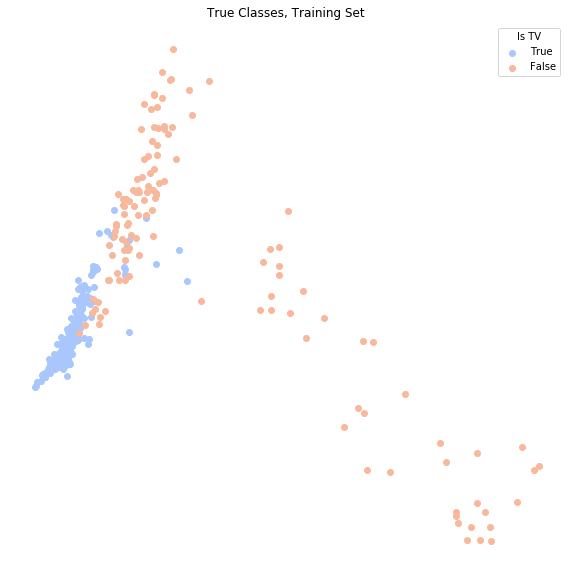

In [353]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot TV
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not TV
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is TV')
plt.title('True Classes, Training Set')
plt.show()

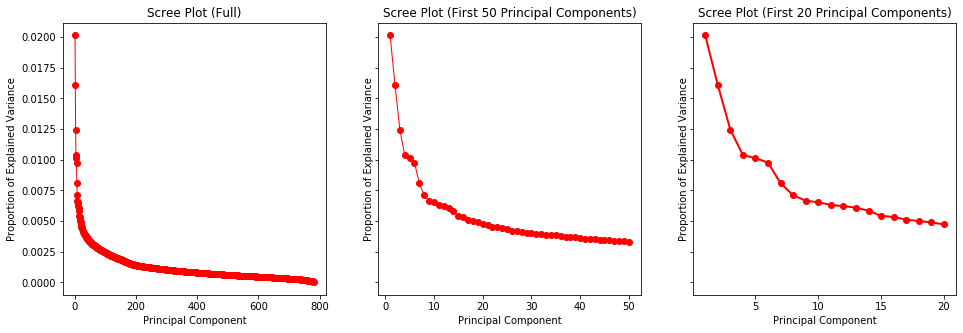

In [354]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 20 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

In [355]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

In [356]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [357]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.9603072983354674

The logistic regression model did pretty well! Now I'll try it on the data that was left for testing.

In [358]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['Text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.9538461538461539

Not quite as good, but pretty successful too. Now I'll try Naïve Bayes.

In [370]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [371]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.942381562099872
Testing:
0.958974358974359


In [364]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0]

This also performed pretty well. Let's look at precision, recall, and f-measure.

In [365]:
sklearn.metrics.precision_score(test_data_df['category'], test_data_df['nb_predict'])

0.9555555555555556

In [366]:
sklearn.metrics.recall_score(test_data_df['category'], test_data_df['nb_predict'])

1.0

In [367]:
sklearn.metrics.f1_score(test_data_df['category'], test_data_df['nb_predict'])

0.9772727272727273

I can also look at these individually for both classes, along with AUC.

In [383]:
lucem_illud.evaluateClassifier(naiveBayes, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.041026,0.826087,1.000000,0.693200,0.652174
True,0.041026,0.826087,0.955556,0.955556,1.000000


And confusion matrices for the model.

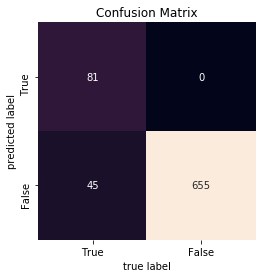

In [384]:
#training data
lucem_illud.plotConfusionMatrix(naiveBayes, train_data_df)

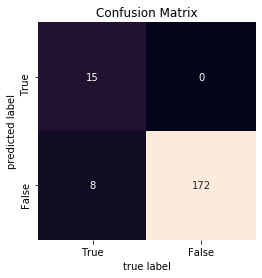

In [385]:
#testing data
lucem_illud.plotConfusionMatrix(naiveBayes, test_data_df)

It looks like about a third of fanfiction stories were falsely predicted to be TV, but no TV was falsely identified as fanfiction. This can also be seen in the graph below.

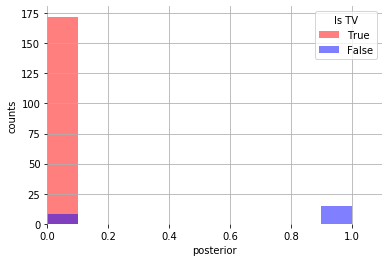

In [387]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['category'].eq(True)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['category'].eq(False)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Is TV")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

Here's an ROC visualization for this model.

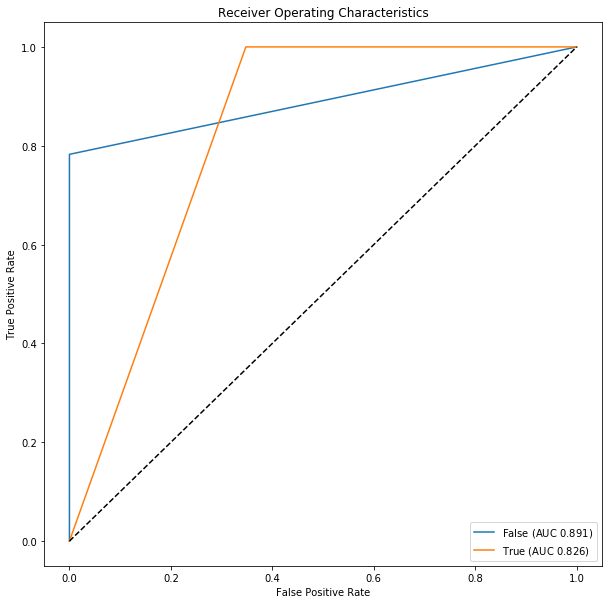

In [388]:
lucem_illud.plotMultiROC(naiveBayes, test_data_df)

I'll also look at the words that are most distinguishing.

In [87]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'TV' : [],
    'TV_log_prob' : [],
    'Fanfic' : [],
    'Fanfic_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:30]:
    words_dict['TV'].append(TFVectorizer.get_feature_names()[i])
    words_dict['TV_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:30]:
    words_dict['Fanfic'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Fanfic_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

,TV,TV_log_prob,Fanfic,Fanfic_log_prob
0,hadn,-0.235829,jamie,-1.957995
1,gaze,-0.246524,brigadier,-2.023953
2,grin,-0.246524,commander,-2.035382
3,shouldn,-0.246524,devil,-2.046942
4,haven,-0.257335,honour,-2.058638
5,wrapped,-0.268264,sergeant,-2.082449
6,shaking,-0.279314,subtitles,-2.082449
7,lip,-0.290487,goodness,-2.094570
8,leaning,-0.313215,chief,-2.106841
9,aren,-0.324776,operate,-2.106841


It definitely seems like the fanfiction is more romance-inclined... words like "gaze," "lip," "kissed."

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

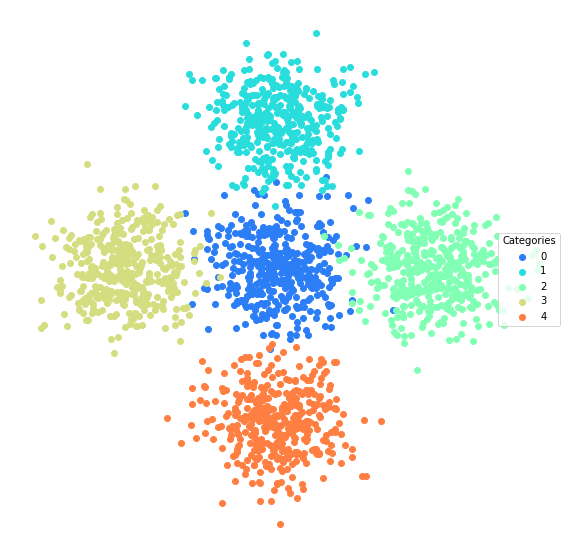

In [143]:
blobs_df = lucem_illud.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = lucem_illud.trainTestSplit(blobs_df)
lucem_illud.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [144]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

To see what's going on visually with the classification: 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

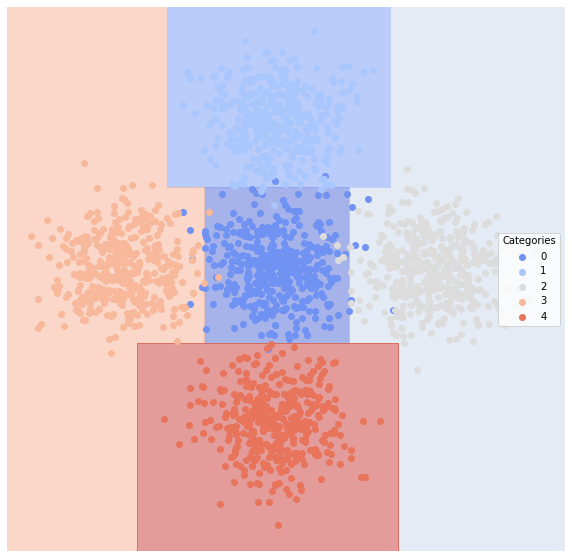

In [145]:
lucem_illud.plotregions(clf_tree, df_exampleTree_train)

In [146]:
lucem_illud.evaluateClassifier(clf_tree, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.026,0.970652,0.893617,0.868803,0.965517
1,0.008,0.981132,1.000000,0.970264,0.962264
2,0.014,0.976057,0.969388,0.938221,0.959596
3,0.000,1.000000,1.000000,1.000000,1.000000
4,0.004,0.990385,1.000000,0.984769,0.980769


Lets look at accuracy:

In [147]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.974

What happens if we trim the tree?

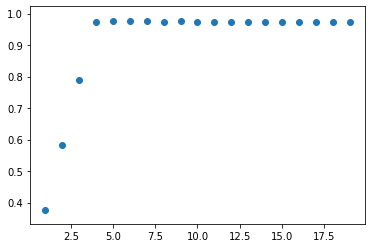

In [148]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [149]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [150]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=10,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,
  

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

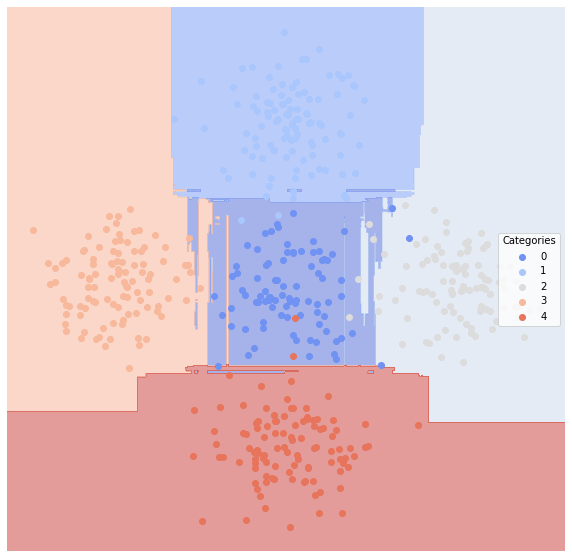

In [152]:
lucem_illud.plotregions(bag, df_exampleTree_test)

In [153]:
lucem_illud.evaluateClassifier(bag, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.022,0.977610,0.904255,0.887468,0.977011
1,0.004,0.990566,1.000000,0.985132,0.981132
2,0.012,0.977304,0.979381,0.947810,0.959596
3,0.002,0.995192,1.000000,0.992385,0.990385
4,0.004,0.990385,1.000000,0.984769,0.980769


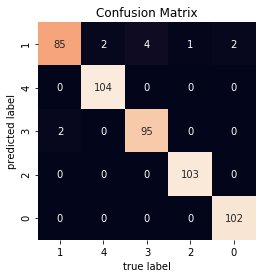

In [154]:
lucem_illud.plotConfusionMatrix(bag, df_exampleTree_test)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

I start with the decision tree classification.

In [395]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [400]:
sklearn.metrics.accuracy_score(test_data_df['category'],clf_tree.predict(np.stack(test_data_df['vect'], axis = 0)))

0.9897435897435898

Quite accurate!

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


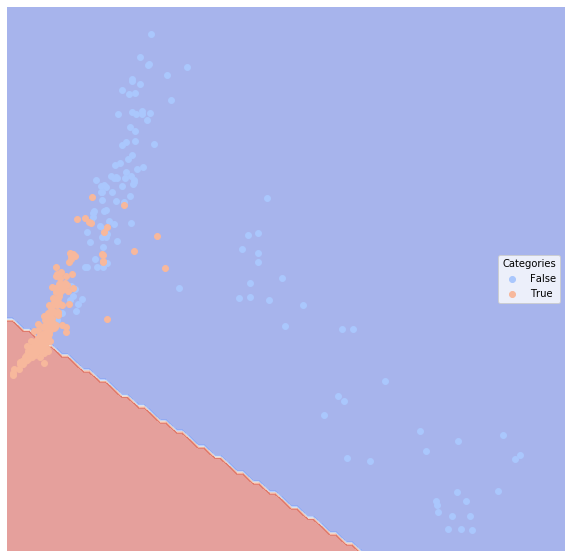

In [401]:
#visualizing classification
lucem_illud.plotregions(clf_tree, train_data_df)

In [402]:
#calculating evulation metrics
lucem_illud.evaluateClassifier(clf_tree, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.010256,0.975354,0.956522,0.920062,0.956522
True,0.010256,0.975354,0.994186,0.993534,0.994186


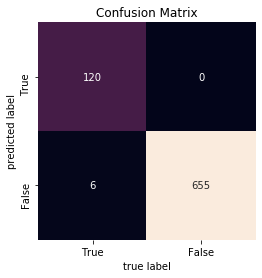

In [410]:
#confusion matrix with training data
lucem_illud.plotConfusionMatrix(clf_tree, train_data_df)

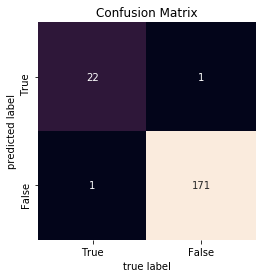

In [409]:
#confusion matrix with testing data
lucem_illud.plotConfusionMatrix(clf_tree, test_data_df)

This is much more accurate than the Naive-Bayes model, with 0.975 AUC as compared to around 0.891 for the Naive-Bayes. Now I'll try the random forest ensemble classifier.

In [403]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [404]:
bag.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=10,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,
  

In [405]:
sklearn.metrics.accuracy_score(test_data_df['category'],bag.predict(np.stack(test_data_df['vect'], axis = 0)))

0.9948717948717949

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


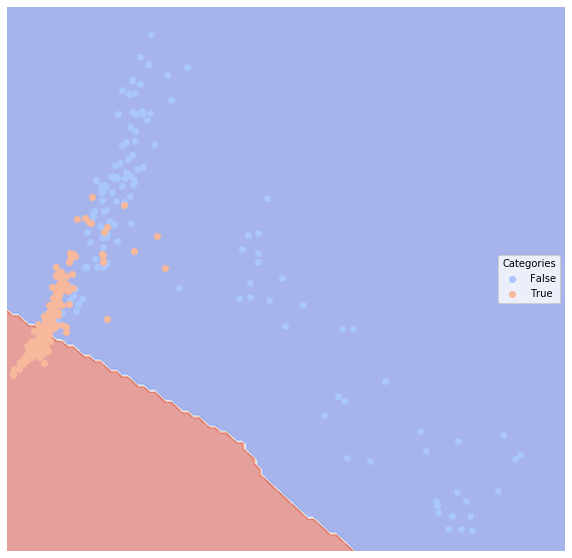

In [406]:
lucem_illud.plotregions(bag, train_data_df)

In [407]:
lucem_illud.evaluateClassifier(bag, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.005128,0.978261,1.00000,0.96165,0.956522
True,0.005128,0.978261,0.99422,0.99422,1.000000


This ensemble classifier works by taking the most votes across a forest of decision trees--for that reason, it's now even more accurate! It still does a little worse for the "false" class, or fanfiction, with lower precision and recall.

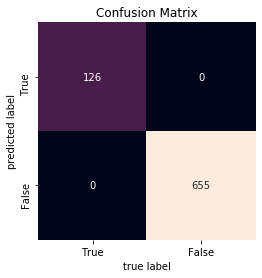

In [412]:
lucem_illud.plotConfusionMatrix(bag, train_data_df)

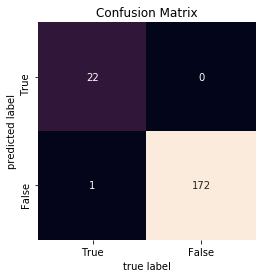

In [408]:
lucem_illud.plotConfusionMatrix(bag, test_data_df)

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data again.

In [427]:
newsgroupsDF[:5]

,text,category,source_file,tokenized_text,normalized_text
0,\n\nParadise and salvation are not the same th...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[Paradise, and, salvation, are, not, the, same...","[paradise, salvation, thing, salvation, well, ..."
1,\nYou're admitting a lot more than that. You ...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[You, 're, admitting, a, lot, more, than, that...","[admit, lot, admit, moral, situational, admit,..."
2,"\n\nJesus also recognized other holy days, lik...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[Jesus, also, recognized, other, holy, days, l...","[jesus, recognize, holy, day, like, passover, ..."
3,In <lsjc8cINNmc1@saltillo.cs.utexas.edu> turpi...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[In, <, lsjc8cINNmc1@saltillo.cs.utexas.edu, >...","[<, lsjc8cinnmc1@saltillo.cs.utexas.edu, >, tu..."
4,"\nI'm sorry, but He does not! Ever read the F...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[I, 'm, sorry, but, He, does, not, Ever, read,...","[be, sorry, read, commandment]"


Make a testing and training set:

In [428]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [429]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [430]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [431]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

In [432]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
talk.religion.misc,0.287870,0.628426,0.302419,0.238267,0.500000
soc.religion.christian,0.257690,0.539419,1.000000,0.336528,0.078838
sci.space,0.413233,0.556843,0.330014,0.301740,0.490486
comp.graphics,0.347069,0.567462,0.366255,0.307613,0.380342


And lets look at the testing data

In [433]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.24651162790697675


Let's produce another confusion matrix:

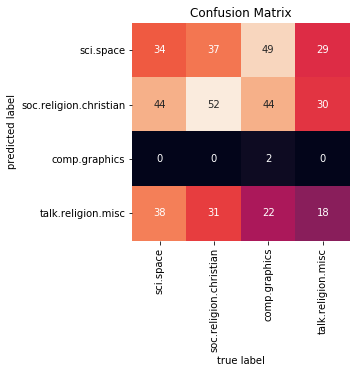

In [434]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [ ]:
#lucem_illud_2020.plotregions(clf_knearest, test_ng_df)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

In [420]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

In [421]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_data_df['Text'])
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [415]:
clf_knearest.fit(np.stack(train_data_df['vect'], axis = 0), train_data_df['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

In [103]:
lucem_illud.evaluateClassifier(clf_knearest, train_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.034571,0.951505,0.851562,0.803579,0.931624
True,0.034571,0.951505,0.987749,0.983813,0.971386


In [104]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_data_df['Text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_data_df['nb_predict'] = clf_knearest.predict(np.stack(test_data_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Testing score:
0.9230769230769231


This model isn't as strong as the decision tree or ensemble models from the last exercise. Here's a visualization of it, and a confusion matrix of the test data.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


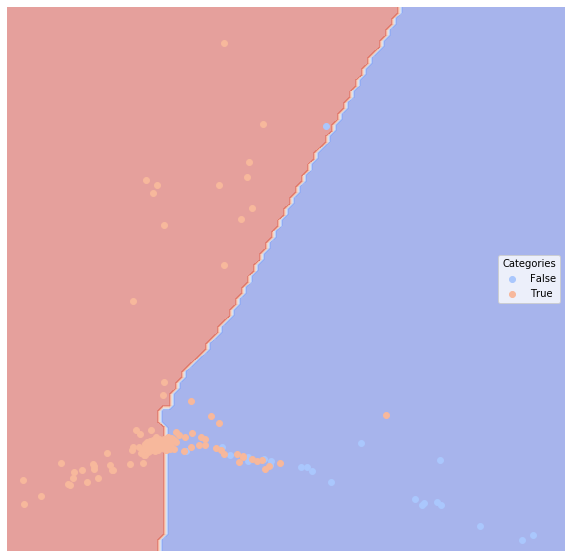

In [417]:
lucem_illud.plotregions(clf_knearest, test_data_df)

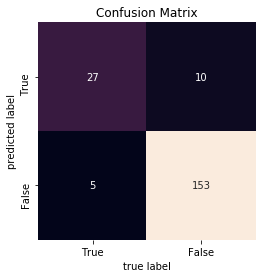

In [105]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_data_df)

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [436]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0)

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

We will tf.idf the data to make our vectors:

In [437]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [438]:
holdBackFraction = .2
train_redditDf, test_redditDf = lucem_illud.trainTestSplit(redditDf, holdBackFraction=holdBackFraction)

In [439]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

...and consider the results:

In [440]:
lucem_illud.evaluateClassifier(clf_svm, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Relationships,0.028213,0.961725,0.967391,0.925102,0.936842
Weeaboo Tales: stories about the extreme fans of japanese culture,0.006270,0.990942,0.985915,0.975164,0.985915
Bad Roommates: Tales of Irritation,0.015674,0.980669,0.961039,0.942018,0.973684
Tales From Tech Support,0.018809,0.978749,0.949367,0.930978,0.974026


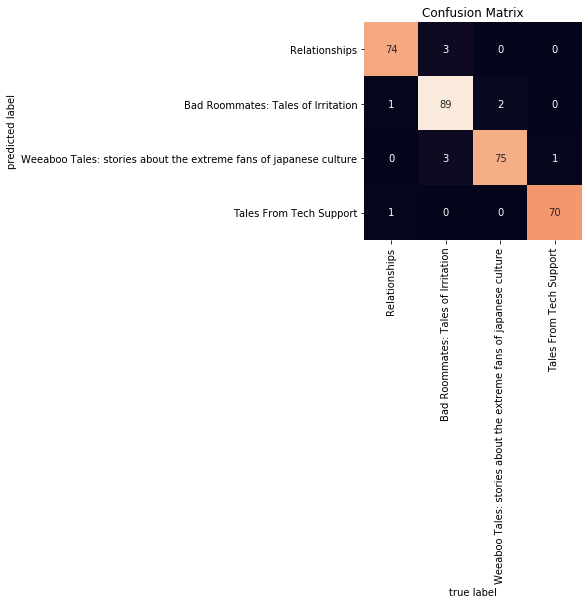

In [441]:
lucem_illud.plotConfusionMatrix(clf_svm, test_redditDf)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

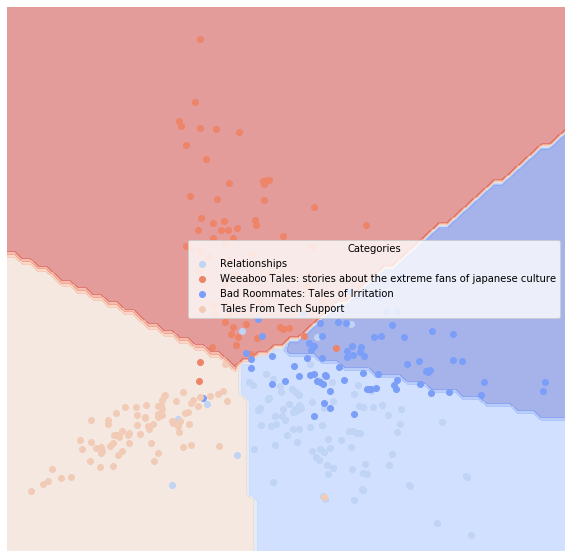

In [442]:
lucem_illud.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [443]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [444]:
lucem_illud.evaluateClassifier(clf_nn, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Relationships,0.028213,0.955663,0.988636,0.930461,0.915789
Weeaboo Tales: stories about the extreme fans of japanese culture,0.009404,0.983899,0.985714,0.964217,0.971831
Bad Roommates: Tales of Irritation,0.018809,0.983133,0.937500,0.928299,0.986842
Tales From Tech Support,0.012539,0.991736,0.950617,0.950617,1.000000


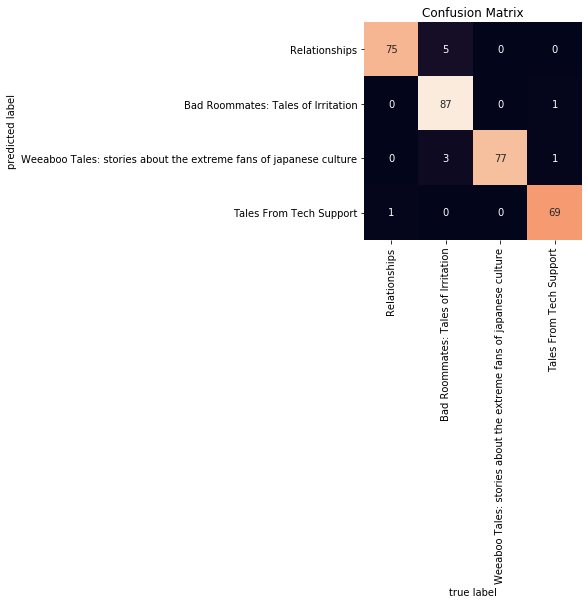

In [445]:
lucem_illud.plotConfusionMatrix(clf_nn, test_redditDf)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

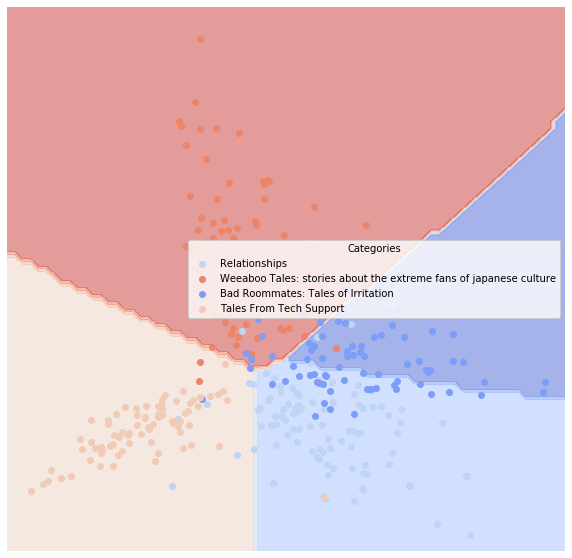

In [446]:
lucem_illud.plotregions(clf_nn, test_redditDf)

It performs very well.

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, Naive Bayes, logistic and decision-tree approaches?

In [448]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [449]:
sklearn.metrics.accuracy_score(test_data_df['category'],clf_nn.predict(np.stack(test_data_df['vect'], axis = 0)))

1.0

In [450]:
lucem_illud.evaluateClassifier(clf_nn, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.0,1.0,1.0,1.0,1.0
True,0.0,1.0,1.0,1.0,1.0


The neural network performed exceptionally well! 1.0 on every metric, so obviously better than any of the other models I've tried.

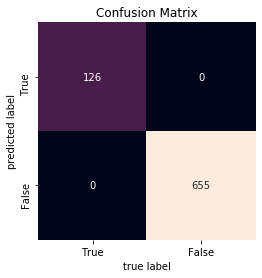

In [451]:
lucem_illud.plotConfusionMatrix(clf_nn, train_data_df)

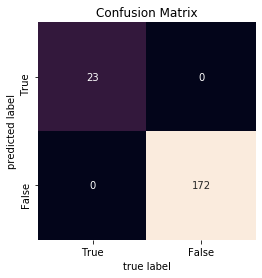

In [452]:
lucem_illud.plotConfusionMatrix(clf_nn, test_data_df)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


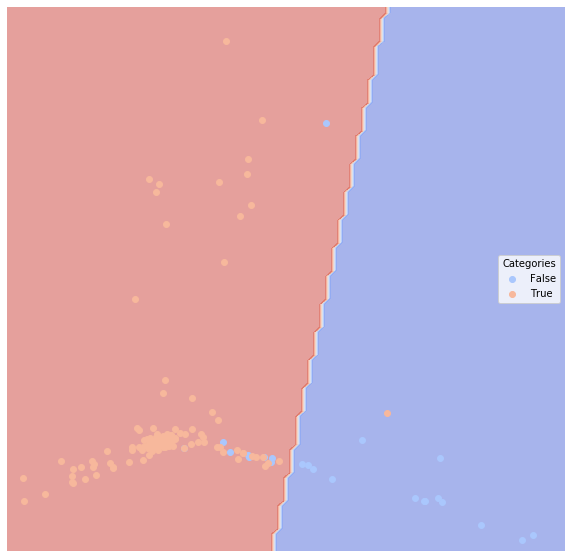

In [453]:
lucem_illud.plotregions(clf_nn, test_data_df)

I'm also going to try the linear SVM.

In [454]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [455]:
sklearn.metrics.accuracy_score(test_data_df['category'],clf_svm.predict(np.stack(test_data_df['vect'], axis = 0)))

0.9948717948717949

In [456]:
lucem_illud.evaluateClassifier(clf_svm, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.005128,0.978261,1.00000,0.96165,0.956522
True,0.005128,0.978261,0.99422,0.99422,1.000000


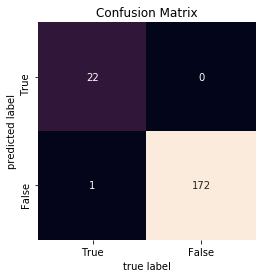

In [457]:
lucem_illud.plotConfusionMatrix(clf_svm, test_data_df)

Pretty good too... but not mistake-free like the neural network model.